In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 22 14:56:44 2020
@author: aborst
"""

import numpy as np
import matplotlib.pyplot as plt
import blindschleiche_py3 as bs
from scipy import ndimage

from scipy import stats
from scipy.signal import savgol_filter
import octopus as oct

In [2]:
mylabelsize = 10
mylegendsize = 10

maxtime = 1000
deltat = 10.0
myt = np.arange(maxtime) * deltat / maxtime

tf = np.zeros(1000)
tf[100:400] = 1.0
tf[600:900] = -1.0
 
noisefac = 0.0

T4d = np.zeros((30, 28, maxtime))
T4c = np.zeros((30, 28, maxtime))
T5d = np.zeros((30, 28, maxtime))
T5c = np.zeros((30, 28, maxtime))

T4T5d = np.zeros((6, 6, maxtime))
T4T5c = np.zeros((6, 6, maxtime))

LPi43 = np.zeros((6, 6, maxtime))
LPi34 = np.zeros((6, 6, maxtime))

T4T5d_mean = np.zeros(maxtime)
T4T5c_mean = np.zeros(maxtime)
LPi43_mean = np.zeros(maxtime)
LPi34_mean = np.zeros(maxtime)

VS = np.zeros(maxtime)
Vx = np.zeros(maxtime)

VSg_total = np.zeros(maxtime)
VSx_total = np.zeros(maxtime)

Vm = np.zeros((6, maxtime))
Vinp = np.zeros((6, maxtime))

In [3]:
# L = LPi, T = T4T5, V = Vertical Cell

defaultLTgain = 0.5 # a
defaultTLgain = 1.0 # b
defaultLLgain = 1.0 # c
defaultTVgain = 1.0 # d
defaultLVgain = 1.0 # e

LVgain = defaultLVgain
LLgain = defaultLLgain
LTgain = defaultLTgain
TVgain = defaultTVgain
TLgain = defaultTLgain

connM = np.zeros((6, 6))

thrld = 0.0

tauT = 20.0
tauLPi = 20.0
tauVS = 20.0

tau = np.array([tauT, tauT, tauLPi, tauLPi, tauVS, tauVS])

In [4]:
# ------ network calculations ------------------------

def set_connM():
    
    global connM
    
    connM[0,:] = [0, 0, 0, -LTgain, 0, 0]
    connM[1,:] = [0, 0, -LTgain, 0, 0, 0]
    connM[2,:] = [TLgain, 0, 0, -LLgain, 0, 0]
    connM[3,:] = [0, TLgain, -LLgain, 0, 0, 0]
    connM[4,:] = [TVgain, 0, 0, -LVgain, 0, 0]
    connM[5,:] = [0, TVgain, -LVgain, 0, 0, 0]
    
    #print('Circuit reset')
    #print(connM)
    
    
def block_feedb():
    
    global connM
    
    connM[0, :] = [0, 0, 0, 0, 0, 0]
    connM[1, :] = [0, 0, 0, 0, 0, 0]
    connM[2, :] = [TLgain, 0, 0, 0, 0, 0]
    connM[3, :] = [0, TLgain, 0, 0, 0, 0]
    connM[4, :] = [TVgain, 0, 0, -LVgain, 0, 0]
    connM[5, :] = [0, TVgain, -LVgain, 0, 0, 0]
    
    #print('Feedback blocked')
    #print(connM)

    
# Block feedback connections from LPi's to T4/T5    
def block_LTgain():
    
    global connM
    
    connM[0,:] = [0, 0, 0, 0, 0, 0]
    connM[1,:] = [0, 0, 0, 0, 0, 0]
    connM[2,:] = [TLgain, 0, 0, -LLgain, 0, 0]
    connM[3,:] = [0, TLgain, -LLgain, 0, 0, 0]
    connM[4,:] = [TVgain, 0, 0, -LVgain, 0, 0]
    connM[5,:] = [0, TVgain, -LVgain, 0, 0, 0]        
    
    #print('LTgain blocked')
    
    
# Block reciprocal connections between LPi's    
def block_LLgain():
    
    global connM
    
    connM[0,:] = [0, 0, 0, -LTgain, 0, 0]
    connM[1,:] = [0, 0, -LTgain, 0, 0, 0]
    connM[2,:] = [TLgain, 0, 0, 0, 0, 0]
    connM[3,:] = [0, TLgain, 0, 0, 0, 0]
    connM[4,:] = [TVgain, 0, 0, -LVgain, 0, 0]
    connM[5,:] = [0, TVgain, -LVgain, 0, 0, 0]   
    
    #print('LLgain blocked')
    

    # block connections from LPi's onto VS cells    
def block_LVgain():
    
    global connM
    
    connM[0,:] = [0, 0, 0, -LTgain, 0, 0]
    connM[1,:] = [0, 0, -LTgain, 0, 0, 0]
    connM[2,:] = [TLgain, 0, 0, -LLgain, 0, 0]
    connM[3,:] = [0, TLgain, -LLgain, 0, 0, 0]
    connM[4,:] = [TVgain, 0, 0, 0, 0, 0]
    connM[5,:] = [0, TVgain, 0, 0, 0, 0]    
    
    #print('LVgain blocked')
    
def block_LPi34_LPi43():
    
    global connM
    
    connM[0,:] = [0, 0, 0, -LTgain, 0, 0]
    connM[1,:] = [0, 0, -LTgain, 0, 0, 0]
    connM[2,:] = [TLgain, 0, 0, 0, 0, 0]
    connM[3,:] = [0, TLgain, -LLgain, 0, 0, 0]
    connM[4,:] = [TVgain, 0, 0, -LVgain, 0, 0]
    connM[5,:] = [0, TVgain, -LVgain, 0, 0, 0]

def block_LPi43_LPi34():
    
    global connM
    
    connM[0,:] = [0, 0, 0, -LTgain, 0, 0]
    connM[1,:] = [0, 0, -LTgain, 0, 0, 0]
    connM[2,:] = [TLgain, 0, 0, -LLgain, 0, 0]
    connM[3,:] = [0, TLgain, 0, 0, 0, 0]
    connM[4,:] = [TVgain, 0, 0, -LVgain, 0, 0]
    connM[5,:] = [0, TVgain, -LVgain, 0, 0, 0]    

def block_LPi43_T4T5c():
    
    global connM
    
    connM[0,:] = [0, 0, 0, -LTgain, 0, 0]
    connM[1,:] = [0, 0, 0, 0, 0, 0]
    connM[2,:] = [TLgain, 0, 0, -LLgain, 0, 0]
    connM[3,:] = [0, TLgain, -LLgain, 0, 0, 0]
    connM[4,:] = [TVgain, 0, 0, -LVgain, 0, 0]
    connM[5,:] = [0, TVgain, -LVgain, 0, 0, 0]

def block_LPi34_T4T5d():
    
    global connM
    
    connM[0,:] = [0, 0, 0, 0, 0, 0]
    connM[1,:] = [0, 0, -LTgain, 0, 0, 0]
    connM[2,:] = [TLgain, 0, 0, -LLgain, 0, 0]
    connM[3,:] = [0, TLgain, -LLgain, 0, 0, 0]
    connM[4,:] = [TVgain, 0, 0, -LVgain, 0, 0]
    connM[5,:] = [0, TVgain, -LVgain, 0, 0, 0] 

def block_LPi43():
    
    global connM
    
    connM[:,2] = 0
    
    #print('LPi4-3 blocked')
    #print(connM)
    
def block_LPi34():
    
    global connM
    
    connM[:, 3] = 0
    
    #print('LPi3-4 blocked')
    #print(connM ) 
    
def block_T4T5c():
    
    global connM
    
    connM[:, 1] = 0
    
    #print('T4T5c blocked')
    #print(connM)
    
def reset_gains():
    
    global LVgain, LLgain, LTgain, TVgain, TLgain
    
    LVgain = defaultLVgain
    LLgain = defaultLLgain
    LTgain = defaultLTgain
    TVgain = defaultTVgain
    TLgain = defaultTLgain
    
    set_connM()
    
set_connM()

def small_network():
    
    for t in range(1,maxtime):

        total_input = connM.dot(bs.rect(Vm[:, t - 1], thrld)) + Vinp[:, t-1]
        Vm[:,t] = deltat / tau * (total_input - Vm[:, t-1]) + Vm[:, t-1]
        
    return Vm

def test_small_network():
    
    set_connM()
    
    Vinp[0] = np.zeros(maxtime)
    Vinp[0, 200:800] = 1.0
    Vinp[1] = np.zeros(maxtime)
    Vinp[1, 200:800] = 1.0
    
    Vm=small_network()
    
    plt.plot(Vm[0], label = 'T4T5d')
    plt.plot(Vm[3], label = 'LPi34')
    plt.legend(loc = 1, frameon = False)
    
def calc_HRBL(lp, hp):
    
    noff = 30
    DC = 0.02
    
    A = bs.rect(lp[:, 0:noff-2, :], 0)
    B = bs.rect(hp[:, 1:noff-1, :], 0)
    C = bs.rect(lp[:, 2:noff-0, :], 0)
    
    Txa = bs.rect(A * B / (DC + C), DC)
    
    A = bs.rect(lp[:, 2:noff-0, :], 0)
    B = bs.rect(hp[:, 1:noff-1, :], 0)
    C = bs.rect(lp[:, 0:noff-2, :], 0)
    
    Txb = bs.rect(A * B / (DC + C), DC)
    
    return Txa, Txb


In [5]:
#  ---------------------------- Large Network ---------------------------------

def large_network():
    
    global T4d,T4c,T5d,T5c,T4T5d_mean,T4T5c_mean,LPi43_mean,LPi34_mean,stimulus,VS,Vx,VSg_total,Vxg_total,gexcVS,ginhVS
    
    syn_gain = 1
    
    n = stimulus.shape
    maxtime = n[2]
    noff = 30
        
    lptau = 50.0 / deltat
    hptau = 250.0 / deltat
        
    R16 = bs.rebin(stimulus, noff, noff, maxtime)
     
    interim = bs.highpass(R16, hptau)
    interim = interim + 0.1 * R16
    L1 = bs.rect(interim, 0)
    L2 = bs.rect(-(interim - 0.05), 0)
    
    ONlp = bs.lowpass(R16, lptau)
    ONhp = L1
    OFFlp = bs.lowpass(1.0 - R16, lptau)
    OFFhp = L2

    T4d, T4c = calc_HRBL(ONlp, ONhp)
    T5d, T5c = calc_HRBL(OFFlp, OFFhp)
    
    for i in range(6):
        
        for j in range(6):
            
            Vinp[0]  = np.mean(bs.rect(T4d[i*5:i*5+5,j*5:j*5+5,:],0), axis=(0,1))
            Vinp[0] += np.mean(bs.rect(T5d[i*5:i*5+5,j*5:j*5+5,:],0), axis=(0,1))
            
            Vinp[1]  = np.mean(bs.rect(T4c[i*5:i*5+5,j*5:j*5+5,:],0), axis=(0,1))
            Vinp[1] += np.mean(bs.rect(T5c[i*5:i*5+5,j*5:j*5+5,:],0), axis=(0,1))
            
            Vm = small_network()
            
            T4T5d[i,j] = Vm[0]
            T4T5c[i,j] = Vm[1]
            LPi43[i,j] = Vm[2]
            LPi34[i,j] = Vm[3]
            
    T4T5d_mean = np.mean(T4T5d,axis = (0,1))
    T4T5c_mean = np.mean(T4T5c,axis = (0,1))
    LPi43_mean = np.mean(LPi43,axis = (0,1))
    LPi34_mean = np.mean(LPi34,axis = (0,1))
    
    T4T5d_mean = T4T5d_mean - np.mean(T4T5d_mean[0:250])
    T4T5c_mean = T4T5c_mean - np.mean(T4T5c_mean[0:250])
    LPi43_mean = LPi43_mean - np.mean(LPi43_mean[0:250])
    LPi34_mean = LPi34_mean - np.mean(LPi34_mean[0:250]) 
    
    # Calculate conductances of VS inputs
    
    gexcVS = np.mean(bs.rect(T4T5d, thrld), axis = (0,1)) * connM[4,0] * syn_gain
    ginhVS = np.mean(bs.rect(LPi34, thrld), axis = (0,1)) * (-connM[4,3]) * syn_gain
    
    gexcVx = np.mean(bs.rect(T4T5c, thrld), axis = (0,1)) * connM[5,1] * syn_gain
    ginhVx = np.mean(bs.rect(LPi43, thrld), axis = (0,1)) * (-connM[5,2]) * syn_gain
        
    VSg_total = gexcVS + ginhVS + 1.0
    Vxg_total = gexcVx + ginhVx + 1.0
    
    
    ## change ginh factor back to 20
    VS = (40.0 * gexcVS - 20.0 * ginhVS) / VSg_total  
    Vx = (40.0 * gexcVx - 20.0 * ginhVx) / Vxg_total
    
    VS = VS - np.mean(VS[0:250])
    Vx = Vx - np.mean(Vx[0:250])
    
    #T4T5d_mean[0:250] = 0
    #T4T5c_mean[0:250] = 0
    #LPi43_mean[0:250] = 0
    #LPi34_mean[0:250] = 0
    #VS[0:250] = 0
    #Vx[0:250] = 0

In [6]:
# -----------------------------------------------------------------------------    
# -------------- create visual stimuli, calculate responses -------------------
# -----------------------------------------------------------------------------
# -------------------sine grating directional tuning --------------------------

def calc_singlewave(img_size, new_spat_freq, x, y):
    
    sinewave = np.sin((np.linspace(0,img_size-1,img_size)-x+y)/img_size*2.0*np.pi*new_spat_freq)
    return sinewave
    
def calc_sine(tf, img_rot, spat_freq, contrast):
    
    print()
    print('rot angle =', img_rot)
    
    n = tf.shape
    maxtime = n[0]
    img_size = 180
    movie = np.zeros((img_size,img_size,maxtime))
    img_rot_rad = img_rot / 360.0 * 2 * np.pi
    new_spat_freq = spat_freq * np.cos(img_rot_rad)
    spat_wlength = img_size / spat_freq
    velo = tf * spat_wlength / 100.0
    
    #print('Spatial Wavelength =', spat_wlength)
    #print('Velocity  (dt=10 msec) =', np.max(np.abs(velo)) * 100, 'deg/s')
    #print('Temp Freq (dt=10 msec) =', np.max(np.abs(tf)), 'Hz')
    
    yshift = np.tan(img_rot_rad)
    
    new_velo = velo / np.cos(img_rot_rad)
    
    if img_rot == 0:
        image = np.zeros((img_size, img_size))
        interim = calc_singlewave(img_size, spat_freq, 0, 0)
        for i in range(img_size):
            image[i,0::] = interim 
        for i in range(maxtime):
            movie[:,:,i] = np.roll(image, int(sum(velo[0:i])), axis=1)      
    else:        
        for i in range(maxtime):
                for y in range(img_size):
                    movie[y,:,i] = calc_singlewave(180,new_spat_freq,int(sum(new_velo[0:i])),int(yshift*y))  
                    
    movie = movie * contrast * 0.5 + 0.5
    
    return movie
    
def store_grating_dir_stimuli_on_disc():
    
    tf = np.zeros(maxtime)
    tf[100:maxtime] = 1.0
    
    dirname = 'C:/Users/gammer/Desktop/DATA Surface/LPi Opponency/Modelling Axel/'
    
    for i in range(12):
    
        angle = i * 30
        print(angle,' deg')
        
        stimulus = calc_sine(tf, angle, 6, 1)
        
        fname = 'Grating' + np.str(angle) + 'deg.npy'
        print(fname)
        
        np.save(dirname + fname, stimulus)
    
def calc_dirtuning():
    
    global stimulus
    
    nofconditions = 4
    nofcells = 6
    nofdirs = 12
    
    dirtuning = np.zeros((nofcells, nofconditions, nofdirs))
    
    dirname='C:/Users/gammer/Desktop/DATA Surface/LPi Opponency/Modelling Axel/'
    
    for direction in range(12):
        
        angle = direction * 30
        print(angle,' deg')
        fname = 'Grating' + np.str(angle) + 'deg.npy'
        stimulus = np.load(dirname + fname)
        
        for condition in range(nofconditions):
            
            reset_gains()
            
            # set condition
            
            if condition == 0: reset_gains()  
            if condition == 1: block_LPi43()
            if condition == 2: block_T4T5c()
            if condition == 3: block_feedb()
        
            large_network()
        
            # assign cells to output array
            
            dirtuning[0,condition,direction] = np.mean(T4T5d_mean[500:maxtime])-np.mean(T4T5d_mean[50:100])
            dirtuning[1,condition,direction] = np.mean(T4T5c_mean[500:maxtime])-np.mean(T4T5c_mean[50:100])
            dirtuning[2,condition,direction] = np.mean(LPi43_mean[500:maxtime])-np.mean(LPi43_mean[50:100])
            dirtuning[3,condition,direction] = np.mean(LPi34_mean[500:maxtime])-np.mean(LPi34_mean[50:100])
            dirtuning[4,condition,direction] = np.mean(VS[500:maxtime])-np.mean(VS[50:100])
            dirtuning[5,condition,direction] = np.mean(Vx[500:maxtime])-np.mean(Vx[50:100])
        
    return dirtuning

In [7]:
#  -------------- transparent motion ------------------------------------------
    
def calc_TM_stimulus(maxtime, velo, index):

    nofdots = 200 # total number of dots in whole movie
    
    PD = [0.0, 12.5, 25.0, 37.5, 50.0, 50.0, 50.0, 50.0, 50.0, 100.0, 0.0]
    ND = [50.0, 50.0, 50.0, 50.0, 50.0, 37.5, 25.0, 12.5, 0.0, 0.0, 100.0]
    ST = [50.0, 37.5, 25.0, 12.5, 0.0, 12.5, 25.0, 37.5, 50.0, 0.00, 0.00]
        
    nofPD_dots = int(PD[index] * 0.01 * nofdots)
    nofND_dots = int(ND[index] * 0.01 * nofdots)
    nofST_dots = int(ST[index] * 0.01 * nofdots)
    
    #print( 'nof dots: ', nofdots)
    #print( 'nof PD d: ', nofPD_dots)
    #print( 'nof ND d: ', nofND_dots)
    #print( 'nof ST d: ', nofST_dots)
    
    movie = np.zeros((200,200,maxtime))
    
    # avoid placing dots on edges by limiting xpos and ypos to bewteen 10 and 190    
    
    PDxpos = np.random.randint(10,190, size=nofPD_dots)
    PDypos = np.random.randint(10,190, size=nofPD_dots)
    
    NDxpos = np.random.randint(10,190, size=nofND_dots)
    NDypos = np.random.randint(10,190, size=nofND_dots)
     
    STxpos = np.random.randint(10,190, size=nofST_dots)
    STypos = np.random.randint(10,190, size=nofST_dots)
    
    # calc individual patch
    
    patch = bs.Gauss2D(5,20)
    patch = patch / np.max(patch)
    
    # set up frames
    
    PDframe = np.zeros((200,200))
    NDframe = np.zeros((200,200))
    STframe = np.zeros((200,200))
    
    # put patches on frames
    
    if nofPD_dots > 0:
    
        interim = np.zeros((200, 200, nofPD_dots))
        for i in range(nofPD_dots):
            interim[PDxpos[i]-10:PDxpos[i]+11,PDypos[i]-10:PDypos[i]+11,i] = patch
        PDframe = interim.max(2)
        
    if nofND_dots>0:
    
        interim = np.zeros((200,200,nofND_dots))
        for i in range(nofND_dots):
            interim[NDxpos[i]-10:NDxpos[i]+11,NDypos[i]-10:NDypos[i]+11,i] = patch
        if nofND_dots>0:
            NDframe = interim.max(2)
            
    if nofST_dots>0:

        interim = np.zeros((200,200,nofST_dots))
        for i in range(nofST_dots):
            interim[STxpos[i]-10:STxpos[i]+11,STypos[i]-10:STypos[i]+11,i] = patch
        if nofST_dots>0:
            STframe = interim.max(2)
    
    # calculate movie
    
    for i in range(maxtime):
        
        f1 = np.roll(PDframe, int(velo*i))
        f2 = np.roll(NDframe, -int(velo*i))
        f3 = STframe
        z = np.stack((f1,f2,f3))
        movie[:,:,i] = z.max(0)
        
    for i in range(250):   
        movie[:,:,i] = movie[:,:,250]
        
    for i in range(250):   
        movie[:,:,i+750] = movie[:,:,750]
        
    return movie
    
def store_TM_stimuli_on_disk():
    
    dirname='C:/Users/gammer/Desktop/DATA Surface/LPi Opponency/Modelling Axel/'

    for i in range(9):
        
        fname = 'TPnoise' + np.str(i) + '.npy'
        stim = calc_TM_stimulus(1000, 1, i)
        np.save(dirname + fname, stim)

def calc_TM_response(nofreps = 1, switch = 2):
    
    # if switch=1: stimulus is read from file on disk
    # if switch=2: stimulus is calculated each time
    
    global LVgain, LLgain, LTgain, TVgain, TLgain, VS, stimulus
    
    nofcells = 6
    nofconditions = 4
    nofstim = 9 # PD, ND, TM
    
    dirname = 'C:/Users/gammer/Desktop/DATA Surface/LPi Opponency/Modelling Axel/'
    fname = ['TPnoise0.npy', 'TPnoise1.npy', 'TPnoise2.npy', 'TPnoise3.npy', 'TPnoise4.npy',
             'TPnoise5.npy', 'TPnoise6.npy', 'TPnoise7.npy', 'TPnoise8.npy',]
    stim_seq = [0, 1, 2, 3, 4, 5, 6, 7, 8]

    TM_response = np.zeros((nofcells, nofconditions, nofstim, maxtime))
    
    for n in range(nofreps):

        for stim in range(9):

            if switch == 1:
                stimulus = np.load(dirname + fname[stim])
                #print('filename=', fname[stim])
            if switch == 2:
                stimulus = calc_TM_stimulus(maxtime, 1, stim_seq[stim])
                #print('calculated new TM stimulus')
                
            stimulus = stimulus[0:180,0:180]
            
            for condition in range(nofconditions):
            
                reset_gains()
                
                # set condition
                
                if condition == 0: reset_gains()  
                if condition == 1: block_LPi43()
                if condition == 2: block_T4T5c()
                if condition == 3: block_feedb()
                if condition == 4: block_LTgain()
                if condition == 5: block_LLgain()
                if condition == 6: block_LVgain()
                    
                    
                large_network()

                TM_response[0,condition,stim] += T4T5d_mean - np.mean(T4T5d_mean[0:100])
                TM_response[1,condition,stim] += T4T5c_mean - np.mean(T4T5c_mean[0:100])
                TM_response[2,condition,stim] += LPi43_mean - np.mean(LPi43_mean[0:100])
                TM_response[3,condition,stim] += LPi34_mean - np.mean(LPi34_mean[0:100])
                TM_response[4,condition,stim] += VS - np.mean(VS[0:100])
                TM_response[5,condition,stim] += Vx - np.mean(Vx[0:100])
            
    TM_response = TM_response / (1.0 * nofreps)
    
    return TM_response

In [8]:
#  -------------- VS conductance change ---------------------------------------

def calc_split_motion_stimulus():
    
    PD_motion = calc_TM_stimulus(1000, 1, 9)
    ND_motion = calc_TM_stimulus(1000, 1, 10)
    split_motion = 1.0 * PD_motion
    split_motion[100:200] = ND_motion[100:200]
    
    return split_motion

def store_split_motion_to_disk():
    
    dirname = 'C:/Users/gammer/Desktop/DATA Surface/LPi Opponency/Modelling Axel/'
    
    stim = calc_split_motion_stimulus()
    np.save(dirname + 'split_motion.npy', stim)


In [9]:
def calc_VS_conductance(condition = 6, switch = 2):
    
    global stimulus
    
    # if switch=1: stimulus is read from file on disk
    # if switch=2: stimulus is calculated each time
    
    VS_cntrl = np.zeros((10, maxtime))
    VS_block = np.zeros((10, maxtime))
    g_cntrl = np.zeros((10, maxtime))
    g_block = np.zeros((10, maxtime))
    ge_cntrl = np.zeros((10, maxtime))
    ge_block = np.zeros((10, maxtime))
    gi_cntrl = np.zeros((10, maxtime))
    gi_block = np.zeros((10, maxtime))
    
    dirname = 'C:/Users/gammer/Desktop/DATA Surface/LPi Opponency/Modelling Axel'
    
    fname = ['TPnoise0.npy', 'TPnoise1.npy', 'TPnoise2.npy', 'TPnoise3.npy', 'TPnoise4.npy',
             'TPnoise5.npy', 'TPnoise6.npy', 'TPnoise7.npy', 'TPnoise8.npy',]
    stim_seq = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    
    for i in range(10):
        
        if switch == 1:
            stimulus = np.load(dirname + fname[i])
            #print(fname[i])
        if switch == 2:
            if i < 9: stimulus = calc_TM_stimulus(maxtime, 1, stim_seq[i])
            if i > 8: stimulus = calc_split_motion_stimulus()
            #print('calculated new TM stimulus') 
            
        stimulus = stimulus[10:190, 10:190]
        
        reset_gains()
        
        large_network()
    
        VS_cntrl[i] = 1.0 * VS
        g_cntrl[i] = 1.0 * VSg_total #/np.mean(VSg_total[1:100])
        ge_cntrl[i] = 1.0 * gexcVS
        gi_cntrl[i] = 1.0 * ginhVS
                
        # set condition
        
        if condition == 0: reset_gains()  
        if condition == 1: block_LPi43()
        if condition == 2: block_T4T5c()
        if condition == 3: block_feedb()
        if condition == 4: block_LTgain()
        if condition == 5: block_LLgain()
        if condition == 6: block_LVgain()
        if condition == 7: block_LPi34()
        if condition == 8: block_LPi34_LPi43()
        if condition == 9: block_LPi43_LPi34()
        if condition == 10: block_LPi43_T4T5c()
        if condition == 11: block_LPi34_T4T5d()
        
        
        large_network()
        
        VS_block[i] = 1.0 * VS
        g_block[i] = 1.0 * VSg_total
        ge_block[i] = 1.0 * gexcVS
        gi_block[i] = 1.0 * ginhVS
        
    return VS_cntrl, VS_block, g_cntrl, g_block, ge_cntrl, gi_cntrl, ge_block, gi_block
        

In [10]:
# ----------------------------------------------------------------------------
                
def calc_all():
    
    dirtuning = calc_dirtuning()
    TM_response = calc_TM_response()
    VS_cntrl, VS_block, g_cntrl, g_block = calc_VS_conductance()
    
    return dirtuning, TM_response, VS_cntrl, VS_block, g_cntrl, g_block, ge_cntrl, gi_cntrl, ge_block, gi_block

In [11]:
#dirtuning = calc_dirtuning()

In [12]:
#TM_response = calc_TM_response()

In [13]:
#VS_cntrl, VS_block, g_cntrl, g_block = calc_VS_conductance()

In [14]:
import time
start = time.time()

rep = 300 # number of stimulus repetitions

VS_cntrl_loop = np.empty([10, 1000, rep])
VS_block_loop = np.empty([10, 1000, rep])
g_cntrl_loop = np.empty([10, 1000, rep])
g_block_loop = np.empty([10, 1000, rep])
ge_cntrl_loop = np.empty([10, 1000, rep])
ge_block_loop = np.empty([10, 1000, rep])
gi_cntrl_loop = np.empty([10, 1000, rep])
gi_block_loop = np.empty([10, 1000, rep])

for i in range (rep):
    VS_cntrl, VS_block, g_cntrl, g_block, ge_cntrl, gi_cntrl, ge_block, gi_block = calc_VS_conductance()
    
    VS_cntrl_loop[:, :, i] = VS_cntrl
    VS_block_loop[:, :, i] = VS_block
    g_cntrl_loop[:, :, i] = g_cntrl
    g_block_loop[:, :, i] = g_block
    ge_cntrl_loop[:, :, i] = ge_cntrl
    ge_block_loop[:, :, i] = ge_block
    gi_cntrl_loop[:, :, i] = gi_cntrl
    gi_block_loop[:, :, i] = gi_block    
    
end = time.time()
print(end - start)

8641.690561294556


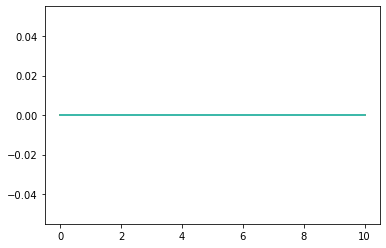

In [15]:
time = np.linspace(0, 10, 1000)
for i in range(rep):
    plt.plot(time, gi_block_loop[0, :, i])

In [16]:
#------------------------------------------------------------------------------    
# ----------------------- Plotting --------------------------------------------
#------------------------------------------------------------------------------

plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
mylabel = ['T4d', 'T4c', 'LPi4-3', 'LPi3-4', 'VS', 'Vx']
block_condition = np.array(['Control', 'LPi4-3 block', 'T4T5c block', 'No Feedback'])


In [17]:
# ----------------- Just for me, no figure in paper --------------------------------

def plot_network(condition):
    
    myt = np.arange(maxtime) * 0.01
    cell_color = ['red','purple','orange','blue','magenta','green']
    cell_type = ['T4T5c','T4T5d','LPi34','LPi43','Vx','VS']
    frame_pos = [1,2,5,6]
    mylw = 2
    
    for j in range(2):
    
        for i in range(4):
            
            if i==0: data = np.mean(T4T5c[j*3:j*3+3],axis=(0,1))
            if i==1: data = np.mean(T4T5d[j*3:j*3+3],axis=(0,1))
            if i==2: data = np.mean(LPi34[j*3:j*3+3],axis=(0,1))
            if i==3: data = np.mean(LPi43[j*3:j*3+3],axis=(0,1))

            if condition==1: 
                mycolor='black'
                mylabel='fb block'
            if condition==2: 
                mycolor=cell_color[i]
                mylabel='control'
            
            ylow = -1.0
            yhigh = 1.5
        
            plt.subplot(3,4,j*2+frame_pos[i])
            
            plt.plot(myt,data,color=mycolor,linewidth=mylw,label=mylabel)
            plt.yticks(np.arange(3)-1,np.arange(3)-1)
            plt.xticks(np.arange(3)*5,'')
            plt.title(cell_type[i])
            plt.ylim(ylow,yhigh)
            plt.xlim(0,10)
            
    for j in range(2):
        
        if j==0: data=Vx
        if j==1: data=VS
        
        if condition==1: 
            mycolor='black'
            mylabel='fb block'
        if condition==2: 
            mycolor=cell_color[4+j]
            mylabel='control'
            
        ylow = -4
        yhigh = 8
    
        plt.subplot(3,4,10+j)
        
        plt.plot(myt,data,color=mycolor,linewidth=mylw,label=mylabel)
        plt.title(cell_type[4+j])
        plt.ylim(ylow,yhigh)
        plt.xticks(np.arange(3)*5,np.arange(3)*5)
        plt.xlim(0,10)
        plt.legend(loc=1,frameon=False)
        plt.xlabel('time [s]')
        

def compare_network():
    
    global stimulus
    
    stimulus = stimulus[10:190,10:190]
    
    plt.figure(figsize = (10,6))
    
    block_feedb()
    large_network()
    plot_network(1)
    
    reset_gains()
    large_network()
    plot_network(2)
    

In [18]:
# Perform baseline subtraction and calculate averages for VS conductances and voltages

delta_g_ctrl_loop = np.empty([10, 1000, rep])
delta_g_block_loop = np.empty([10, 1000, rep])
delta_ge_ctrl_loop = np.empty([10, 1000, rep])
delta_ge_block_loop = np.empty([10, 1000, rep])
delta_gi_ctrl_loop = np.empty([10, 1000, rep])
delta_gi_block_loop = np.empty([10, 1000, rep])

delta_VS_ctrl_loop = np.empty([10, 1000, rep])
delta_VS_block_loop = np.empty([10, 1000, rep])


for i in range(rep):
    for j in range(10):
        delta_g_ctrl_loop[j, :, i] = g_cntrl_loop[j, :, i] - np.mean(g_cntrl_loop[j, 100:200, i])
        delta_g_block_loop[j, :, i] = g_block_loop[j, :, i] - np.mean(g_block_loop[j, 100:200, i])
        delta_ge_ctrl_loop[j, :, i] = ge_cntrl_loop[j, :, i] - np.mean(ge_cntrl_loop[j, 100:200, i])
        delta_ge_block_loop[j, :, i] = ge_block_loop[j, :, i] - np.mean(ge_block_loop[j, 100:200, i])
        delta_gi_ctrl_loop[j, :, i] = gi_cntrl_loop[j, :, i] - np.mean(gi_cntrl_loop[j, 100:200, i])
        delta_gi_block_loop[j, :, i] = gi_block_loop[j, :, i] - np.mean(gi_block_loop[j, 100:200, i])
        
        delta_VS_ctrl_loop[j, :, i] = VS_cntrl_loop[j, :, i] - np.mean(VS_cntrl_loop[j, 100:200, i])
        delta_VS_block_loop[j, :, i] = VS_block_loop[j, :, i] - np.mean(VS_block_loop[j, 100:200, i])
        
delta_g_ctrl_mean = np.mean(delta_g_ctrl_loop[:, 250:750, :], 1)
delta_g_block_mean = np.mean(delta_g_block_loop[:, 250:750, :], 1)
delta_ge_ctrl_mean = np.mean(delta_ge_ctrl_loop[:, 250:750, :], 1)
delta_ge_block_mean = np.mean(delta_ge_block_loop[:, 250:750, :], 1)
delta_gi_ctrl_mean = np.mean(delta_gi_ctrl_loop[:, 250:750, :], 1)
delta_gi_block_mean = np.mean(delta_gi_block_loop[:, 250:750, :], 1)

delta_VS_ctrl_mean = np.mean(delta_VS_ctrl_loop[:, 250:750, :], 1)
delta_VS_block_mean = np.mean(delta_VS_block_loop[:, 250:750, :], 1)

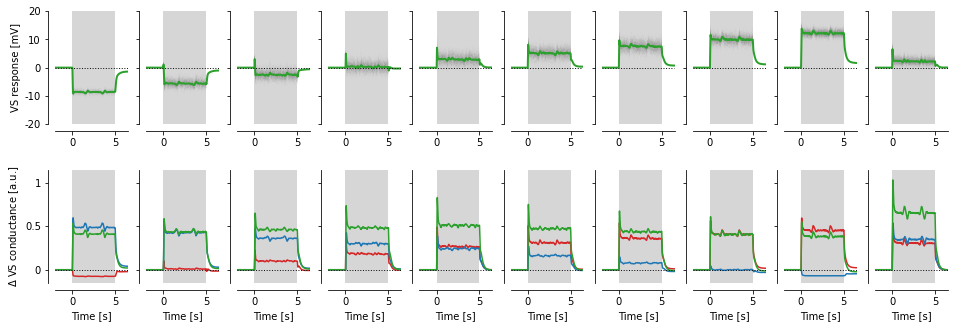

In [19]:
    ymax_Vm = 20
    ymin_DC = -0.15
    ymax_DC = 1.15
    
    fig = plt.figure(figsize = (16, 5))
    plt.subplots_adjust(wspace = 0.25)
    plt.subplots_adjust(hspace = 0.4)
    
    for i in range(10):
            
        ax = fig.add_subplot(2, 10, i+1)
        
        plt.plot(delta_VS_ctrl_loop[i,:,:], color = 'C2', alpha = 0.01, label = 'Ctrl', linewidth = 0.1)
        plt.plot(np.mean(delta_VS_ctrl_loop[i,:,:],1), color = 'C2', label = 'Ctrl', linewidth = 2)
        
        ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)
        plt.axvspan(250, 750, facecolor='0.2', alpha=0.2)
        
        if i == 0: plt.ylabel('VS response [mV]')
        if i == 0: plt.yticks([-20, -10, 0, 10, 20], [-20, -10, 0, 10, 20])
        else: plt.yticks([-20, -10, 0, 10, 20], [])
        
        plt.xticks([250, 750], [0, 5])
        plt.xlim(50, 900)
        plt.ylim(-ymax_Vm, ymax_Vm)
        #plt.title(titel[i], fontsize=11)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines['left'].set_position(('outward', 7))
        ax.spines['bottom'].set_position(('outward', 7))
        
        
        ax = fig.add_subplot(2, 10, i+11)
        
        #plt.plot(delta_g_ctrl_loop[i,:,:], color = 'C2', alpha = 0.05, label = 'Ctrl', linewidth = 0.5)
        plt.plot(np.mean(delta_ge_ctrl_loop[i,:,:],1), color = 'C3', label = 'Ctrl', linewidth = 1.5)
        plt.plot(np.mean(delta_gi_ctrl_loop[i,:,:],1), color = 'C0', label = 'Ctrl', linewidth = 1.5)
        plt.plot(np.mean(delta_g_ctrl_loop[i,:,:],1), color = 'C2', label = 'Ctrl', linewidth = 1.5)
      
        ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)
        plt.axvspan(250, 750, facecolor='0.2', alpha=0.2)
        
        if i == 0: plt.ylabel(r'$\Delta$' + ' VS conductance [a.u.]')
        if i == 0: plt.yticks([0, 0.5, 1, 1.5], [0, 0.5, 1, 1.5])
        else: plt.yticks([0, 0.5, 1, 1.5], [])
        
        plt.xticks([250, 750], [0, 5])
        plt.xlabel('Time [s]')
        plt.xlim(50, 900)
        plt.ylim(ymin_DC,ymax_DC)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines['left'].set_position(('outward', 7))
        ax.spines['bottom'].set_position(('outward', 7))
        
bbox_inches = 'tight'
#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\Modelling\\\
#FigS7_Coherences_traces_VS_ctrl_300rep.pdf',bbox_inches='tight', dpi=600, transparent=True)
plt.show()

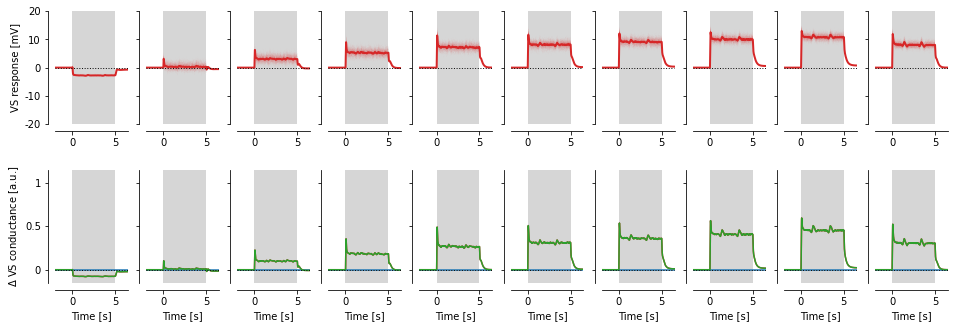

In [20]:
    ymax_Vm = 20
    ymin_DC = -0.15
    ymax_DC = 1.15
    
    fig = plt.figure(figsize = (16, 5))
    plt.subplots_adjust(wspace = 0.25)
    plt.subplots_adjust(hspace = 0.4)
    
    for i in range(10):
            
        ax = fig.add_subplot(2, 10, i+1)
        
        plt.plot(delta_VS_block_loop[i,:,:], color = 'C3', alpha = 0.01, label = 'block', linewidth = 0.1)
        plt.plot(np.mean(delta_VS_block_loop[i,:,:],1), color = 'C3', label = 'block', linewidth = 2)
        
        ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)
        plt.axvspan(250, 750, facecolor='0.2', alpha=0.2)
        
        if i == 0: plt.ylabel('VS response [mV]')
        if i == 0: plt.yticks([-20, -10, 0, 10, 20], [-20, -10, 0, 10, 20])
        else: plt.yticks([-20, -10, 0, 10, 20], [])
        
        plt.xticks([250, 750], [0, 5])
        plt.xlim(50, 900)
        plt.ylim(-ymax_Vm, ymax_Vm)
        #plt.title(titel[i], fontsize=11)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines['left'].set_position(('outward', 7))
        ax.spines['bottom'].set_position(('outward', 7))
        
        
        ax = fig.add_subplot(2, 10, i+11)
        
        #plt.plot(delta_g_block_loop[i,:,:], color = 'C2', alpha = 0.05, label = 'block', linewidth = 0.5)
        plt.plot(np.mean(delta_ge_block_loop[i,:,:],1), color = 'C3', label = 'block', linewidth = 1.5)
        plt.plot(np.mean(delta_gi_block_loop[i,:,:],1), color = 'C0', label = 'block', linewidth = 1.5)
        plt.plot(np.mean(delta_g_block_loop[i,:,:],1), color = 'C2', label = 'block', linewidth = 1.5)
      
        ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)
        plt.axvspan(250, 750, facecolor='0.2', alpha=0.2)
        
        if i == 0: plt.ylabel(r'$\Delta$' + ' VS conductance [a.u.]')
        if i == 0: plt.yticks([0, 0.5, 1, 1.5], [0, 0.5, 1, 1.5])
        else: plt.yticks([0, 0.5, 1, 1.5], [])
        
        plt.xticks([250, 750], [0, 5])
        plt.xlabel('Time [s]')
        plt.xlim(50, 900)
        plt.ylim(ymin_DC,ymax_DC)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines['left'].set_position(('outward', 7))
        ax.spines['bottom'].set_position(('outward', 7))
        
bbox_inches = 'tight'
plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\Modelling\\\
FigS7_Coherence_traces_VS_LV_block_300rep.pdf',bbox_inches='tight', dpi=600, transparent=True)
plt.show()

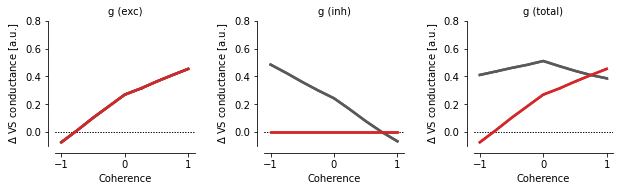

In [21]:
coh = np.array([-0.5, -0.375, -0.25, -0.125, 0, 0.125, 0.25, 0.375, 0.5])*2

title = ['g (exc)', 'g (inh)', 'g (total)']
data_ctrl = [delta_ge_ctrl_mean, delta_gi_ctrl_mean, delta_g_ctrl_mean]
data_block = [delta_ge_block_mean, delta_gi_block_mean, delta_g_block_mean]

fig = plt.figure(figsize = (10, 2.3))
plt.subplots_adjust(wspace = 0.5)

for i in range (len(data_ctrl)):
    
    ax = fig.add_subplot(1, 3, i+1) #PLOT coherence tuning

    ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)
    plt.plot(coh, np.mean(data_ctrl[i],1)[0:9], linewidth = 2.5, color = '0.35')
    plt.errorbar(coh, np.mean(data_ctrl[i],1)[0:9], yerr = stats.sem(data_ctrl[i],1)[0:9],
                 linewidth = 2.5, color = '0.35')

    ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)
    plt.plot(coh, np.mean(data_block[i],1)[0:9], linewidth = 2.5, color = 'C3')
    plt.errorbar(coh, np.mean(data_block[i],1)[0:9], yerr = stats.sem(data_block[i],1)[0:9],
                 linewidth = 2.5, color = 'C3')

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines['left'].set_position(('outward', 7))
    ax.spines['bottom'].set_position(('outward', 7))
    #for axis in ['top','bottom','left','right']:
    #  ax.spines[axis].set_linewidth(0.5)
    ax.set_xlabel('Coherence', fontsize = 10)
    ax.set_ylabel(r'$\Delta$' + ' VS conductance [a.u.]', fontsize = 10)
    plt.ylim([-0.1,0.8])
    plt.title(title[i], fontsize = 10)
    
plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\Modelling\\\
FigS7_Coherence_tuning_VS_LV_block_ge_gi_300rep.pdf',bbox_inches='tight', dpi=600, transparent=True)

bbox_inches = 'tight'
plt.show()

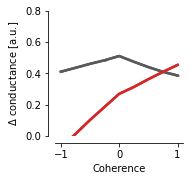

In [22]:
coh = np.array([-0.5, -0.375, -0.25, -0.125, 0, 0.125, 0.25, 0.375, 0.5])*2

fig = plt.figure(figsize = (2.3, 2.3))

ax = fig.add_subplot(111) #PLOT coherence tuning

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)
plt.plot(coh, np.mean(delta_g_ctrl_mean,1)[0:9], linewidth = 2.5, color = '0.35')
plt.errorbar(coh, np.mean(delta_g_ctrl_mean,1)[0:9], yerr = stats.sem(delta_g_ctrl_mean,1)[0:9],
            linewidth = 2.5, color = '0.35')

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)
plt.plot(coh, np.mean(delta_g_block_mean,1)[0:9], linewidth = 2.5, color = 'C3')
plt.errorbar(coh, np.mean(delta_g_block_mean,1)[0:9], yerr = stats.sem(delta_g_block_mean,1)[0:9],
            linewidth = 2.5, color = 'C3')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
ax.set_xlabel('Coherence', fontsize = 10)
ax.set_ylabel(r'$\Delta$' + ' conductance [a.u.]', fontsize = 10)
plt.ylim([0,0.8])

plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\Modelling\\\
FigS7_Coherence_tuning_VS_LV_block_mV_only_total_300rep.pdf',bbox_inches='tight', dpi=600, transparent=True)

bbox_inches = 'tight'
plt.show()

In [23]:
delta_ge_ctrl_min_block = delta_ge_ctrl_mean - delta_ge_block_mean
delta_gi_ctrl_min_block = delta_gi_ctrl_mean - delta_gi_block_mean
delta_g_ctrl_min_block = delta_g_ctrl_mean - delta_g_block_mean

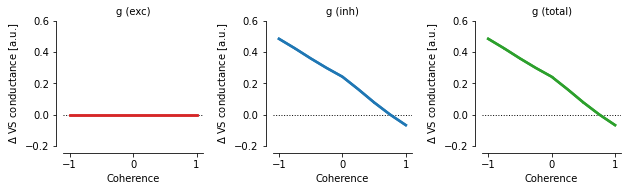

In [28]:
coh = np.array([-0.5, -0.375, -0.25, -0.125, 0, 0.125, 0.25, 0.375, 0.5])*2

title = ['g (exc)', 'g (inh)', 'g (total)']
data = [delta_ge_ctrl_min_block, delta_gi_ctrl_min_block, delta_g_ctrl_min_block]
color = ['C3', 'C0', 'C2']

fig = plt.figure(figsize = (10, 2.3))
plt.subplots_adjust(wspace = 0.5)

for i in range (len(data)):
    
    ax = fig.add_subplot(1, 3, i+1) #PLOT coherence tuning

    ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)
    plt.plot(coh, np.mean(data[i],1)[0:9], linewidth = 2.5, color = color[i])
    plt.errorbar(coh, np.mean(data[i],1)[0:9], yerr = stats.sem(data[i],1)[0:9],
             linewidth = 2.5, color = color[i])
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines['left'].set_position(('outward', 7))
    ax.spines['bottom'].set_position(('outward', 7))
    #for axis in ['top','bottom','left','right']:
    #  ax.spines[axis].set_linewidth(0.5)
    ax.set_xlabel('Coherence', fontsize = 10)
    ax.set_ylabel(r'$\Delta$' + ' VS conductance [a.u.]', fontsize = 10)
    plt.ylim([-0.2,0.6])
    plt.title(title[i], size=10)
    
plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\Modelling\\\
FigS7_Coherence_tuning_VS_LV_block_minus_ctrl_300rep.pdf',bbox_inches='tight', dpi=600, transparent=True)

bbox_inches = 'tight'
plt.show()

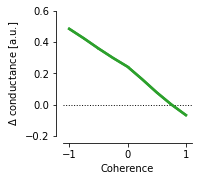

In [30]:
coh = np.array([-0.5, -0.375, -0.25, -0.125, 0, 0.125, 0.25, 0.375, 0.5])*2

fig = plt.figure(figsize = (2.3, 2.3))

ax = fig.add_subplot(111) #PLOT coherence tuning

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)
plt.plot(coh, np.mean(delta_g_ctrl_min_block,1)[0:9], linewidth = 2.5, color = 'C2')
plt.errorbar(coh, np.mean(delta_g_ctrl_min_block,1)[0:9], yerr = stats.sem(delta_g_ctrl_min_block,1)[0:9],
        linewidth = 2.5, color = color[i])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
#for axis in ['top','bottom','left','right']:
#  ax.spines[axis].set_linewidth(0.5)
ax.set_xlabel('Coherence', fontsize = 10)
ax.set_ylabel(r'$\Delta$' + ' conductance [a.u.]', fontsize = 10)
plt.ylim([-0.2,0.6])

plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\Modelling\\\
FigS7_Coherence_tuning_VS_LV_block_minus_ctrl_only_total_300rep.pdf',bbox_inches='tight', dpi=600, transparent=True)

bbox_inches = 'tight'
plt.show()

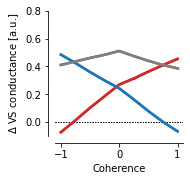

In [31]:
coh = np.array([-0.5, -0.375, -0.25, -0.125, 0, 0.125, 0.25, 0.375, 0.5])*2

fig = plt.figure(figsize = (2.3, 2.3))

ax = fig.add_subplot(111) #PLOT coherence tuning

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)
plt.plot(coh, np.mean(delta_ge_ctrl_mean,1)[0:9], linewidth = 2.5, color = 'C3')
plt.errorbar(coh, np.mean(delta_ge_ctrl_mean,1)[0:9], yerr = stats.sem(delta_ge_ctrl_mean,1)[0:9],
             linewidth = 2.5, color = 'C3')

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)
plt.plot(coh, np.mean(delta_gi_ctrl_mean,1)[0:9], linewidth = 2.5, color = 'C0')
plt.errorbar(coh, np.mean(delta_gi_ctrl_mean,1)[0:9], yerr = stats.sem(delta_gi_ctrl_mean,1)[0:9],
             linewidth = 2.5, color = 'C0')

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)
plt.plot(coh, np.mean(delta_g_ctrl_mean,1)[0:9], linewidth = 2.5, color = '0.35')
plt.errorbar(coh, np.mean(delta_g_ctrl_mean,1)[0:9], yerr = stats.sem(delta_g_ctrl_mean,1)[0:9],
             linewidth = 2.5, color = '0.5')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
#for axis in ['top','bottom','left','right']:
#  ax.spines[axis].set_linewidth(0.5)
ax.set_xlabel('Coherence', fontsize = 10)
ax.set_ylabel(r'$\Delta$' + ' VS conductance [a.u.]', fontsize = 10)
plt.ylim([-0.1,0.8])

#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\\
#FigS7_Coherence_tuning_VS_LPi34_block_g.pdf',bbox_inches='tight', dpi=600, transparent=True)

bbox_inches = 'tight'
plt.show()

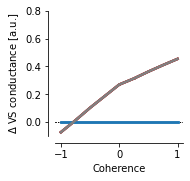

In [32]:
coh = np.array([-0.5, -0.375, -0.25, -0.125, 0, 0.125, 0.25, 0.375, 0.5])*2

fig = plt.figure(figsize = (2.3, 2.3))

ax = fig.add_subplot(111) #PLOT coherence tuning

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)
plt.plot(coh, np.mean(delta_ge_block_mean,1)[0:9], linewidth = 2.5, color = 'C3')
plt.errorbar(coh, np.mean(delta_ge_block_mean,1)[0:9], yerr = stats.sem(delta_ge_block_mean,1)[0:9],
             linewidth = 2.5, color = 'C3')

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)
plt.plot(coh, np.mean(delta_gi_block_mean,1)[0:9], linewidth = 2.5, color = 'C0')
plt.errorbar(coh, np.mean(delta_gi_block_mean,1)[0:9], yerr = stats.sem(delta_gi_block_mean,1)[0:9],
             linewidth = 2.5, color = 'C0')

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)
plt.plot(coh, np.mean(delta_g_block_mean,1)[0:9], linewidth = 2.5, color = '0.35')
plt.errorbar(coh, np.mean(delta_g_block_mean,1)[0:9], yerr = stats.sem(delta_g_block_mean,1)[0:9],
             linewidth = 2.5, color = '0.5')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
#for axis in ['top','bottom','left','right']:
#  ax.spines[axis].set_linewidth(0.5)
ax.set_xlabel('Coherence', fontsize = 10)
ax.set_ylabel(r'$\Delta$' + ' VS conductance [a.u.]', fontsize = 10)
plt.ylim([-0.1,0.8])

#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\\
#FigS7_Coherence_tuning_VS_LPi34_block_g.pdf',bbox_inches='tight', dpi=600, transparent=True)

bbox_inches = 'tight'
plt.show()

In [33]:
# Save conductance mean data

np.save('delta_ge_LV_ctrl_300rep.npy', delta_ge_ctrl_mean)
np.save('delta_gi_LV_ctrl_300rep.npy', delta_gi_ctrl_mean)
np.save('delta_g_LV_ctrl_300rep.npy', delta_g_ctrl_mean) 
np.save('delta_ge_LV_block_300rep.npy', delta_ge_block_mean)
np.save('delta_gi_LV_block_300rep.npy', delta_gi_block_mean)
np.save('delta_g_LV_block_300rep.npy', delta_g_block_mean) 

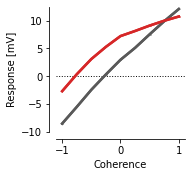

In [34]:
coh = np.array([-0.5, -0.375, -0.25, -0.125, 0, 0.125, 0.25, 0.375, 0.5])*2

fig = plt.figure(figsize = (2.3, 2.3))

ax = fig.add_subplot(111) #PLOT coherence tuning

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)
plt.plot(coh, np.mean(delta_VS_ctrl_mean,1)[0:9], linewidth = 2.5, color = '0.35')
plt.errorbar(coh, np.mean(delta_VS_ctrl_mean,1)[0:9], yerr = stats.sem(delta_VS_ctrl_mean,1)[0:9],
             linewidth = 2.5, color = '0.35')

plt.plot(coh, np.mean(delta_VS_block_mean,1)[0:9], linewidth = 2.5, color = 'C3')
plt.errorbar(coh, np.mean(delta_VS_block_mean,1)[0:9], yerr = stats.sem(delta_VS_block_mean,1)[0:9],
             linewidth = 2.5, color = 'C3')


ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
#for axis in ['top','bottom','left','right']:
#  ax.spines[axis].set_linewidth(0.5)
ax.set_xlabel('Coherence', fontsize = 10)
ax.set_ylabel('Response [mV]', fontsize = 10)
#xticks = np.array([-0.5, -0.25, 0, 0.25, 0.5])
#ax.set_xticklabels([-0.5, -0.25, 0, 0.25, 0.5], size=10)
plt.ylim([-10,12.5])
#ax.set_xticks(xticks)
#ax.set_yticks([-5, 0, 5])
#ax.set_yticklabels([-5, 0, 5], size=10)

plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\Modelling\\\
FigS7_Coherence_tuning_VS_LV_block_mV_300rep.pdf',bbox_inches='tight', dpi=600, transparent=True)

bbox_inches = 'tight'
plt.show()

In [35]:
delta_VS_ctrl_min_block = delta_VS_ctrl_mean - delta_VS_block_mean

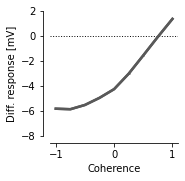

In [40]:
coh = np.array([-0.5, -0.375, -0.25, -0.125, 0, 0.125, 0.25, 0.375, 0.5])*2

fig = plt.figure(figsize = (2.3, 2.3))

ax = fig.add_subplot(111) #PLOT coherence tuning

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)
plt.plot(coh, np.mean(delta_VS_ctrl_min_block,1)[0:9], linewidth = 2.5, color = '0.35')
plt.errorbar(coh, np.mean(delta_VS_ctrl_min_block,1)[0:9], yerr = stats.sem(delta_VS_ctrl_min_block,1)[0:9],
             linewidth = 2.5, color = '0.35')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
#for axis in ['top','bottom','left','right']:
#  ax.spines[axis].set_linewidth(0.5)
ax.set_xlabel('Coherence', fontsize = 10)
ax.set_ylabel('Diff. response [mV]', fontsize = 10)
plt.ylim([-8,2])

plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\Modelling\\\
FigS7_Coherence_tuning_VS_ctrl_minus_LV_block_mV_300rep.pdf',bbox_inches='tight', dpi=600, transparent=True)

bbox_inches = 'tight'
plt.show()

In [41]:
# linear fit
slope_int_ctrl = np.empty([2,rep])
for i in range(len(delta_VS_ctrl_mean[0,:])):
    slope, intercept, r_value, p_value, std_err = stats.linregress(coh[0:9], delta_VS_ctrl_mean[0:9,i])
    slope_int_ctrl[0,i] = slope
    slope_int_ctrl[1,i] = -intercept/slope

slope_int_block = np.empty([2,rep])
for i in range(len(delta_VS_block_mean[0,:])):
    slope, intercept, r_value, p_value, std_err = stats.linregress(coh[0:9], delta_VS_block_mean[0:9,i])
    slope_int_block[0,i] = slope
    slope_int_block[1,i] = -intercept/slope
    
#np.save('slope_int_ctrl_300rep.npy', slope_int_ctrl)
np.save('VS_mV_LV_ctrl_300rep.npy', delta_VS_ctrl_mean)

#np.save('slope_int_LT_block_300rep.npy', slope_int_block) 
np.save('VS_mV_LV_block_300rep.npy', delta_VS_block_mean)

In [42]:
slope_coh_ctrl = np.zeros([9,rep])
for i in range(len(delta_VS_ctrl_mean[0,:])):
    slope, intercept, r_value, p_value, std_err = stats.linregress(coh[0:2], delta_VS_ctrl_mean[0:2,i])
    slope_coh_ctrl[0,i] = slope
    slope, intercept, r_value, p_value, std_err = stats.linregress(coh[7:9], delta_VS_ctrl_mean[7:9,i])
    slope_coh_ctrl[8,i] = slope   
    for j in [1,2,3,4,5,6,7]:   
        slope, intercept, r_value, p_value, std_err = stats.linregress(coh[j-1:j+2], delta_VS_ctrl_mean[j-1:j+2,i])
        slope_coh_ctrl[j,i] = slope 

In [43]:
slope_coh_block = np.zeros([9,rep])
for i in range(len(delta_VS_block_mean[0,:])):
    slope, intercept, r_value, p_value, std_err = stats.linregress(coh[0:2], delta_VS_block_mean[0:2,i])
    slope_coh_block[0,i] = slope
    slope, intercept, r_value, p_value, std_err = stats.linregress(coh[7:9], delta_VS_block_mean[7:9,i])
    slope_coh_block[8,i] = slope   
    for j in [1,2,3,4,5,6,7]:   
        slope, intercept, r_value, p_value, std_err = stats.linregress(coh[j-1:j+2], delta_VS_block_mean[j-1:j+2,i])
        slope_coh_block[j,i] = slope 

In [44]:
np.save('slope_coh_LV_ctrl_300rep.npy', slope_coh_ctrl)
np.save('slope_coh_LV_block_300rep.npy', slope_coh_block)

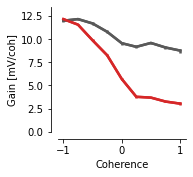

In [45]:
fig = plt.figure(figsize = (2.3, 2.3))

ax = fig.add_subplot(111) #PLOT slopes of coherence tuning

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)
plt.plot(coh, np.mean(slope_coh_ctrl,1), linewidth = 2.5, color = '0.35')
plt.errorbar(coh, np.mean(slope_coh_ctrl,1), yerr = stats.sem(slope_coh_ctrl,1),
             linewidth = 2.5, color = '0.35')

plt.plot(coh, np.mean(slope_coh_block,1), linewidth = 2.5, color = 'C3')
plt.errorbar(coh, np.mean(slope_coh_block,1), yerr = stats.sem(slope_coh_block,1),
             linewidth = 2.5, color = 'C3')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
#for axis in ['top','bottom','left','right']:
#  ax.spines[axis].set_linewidth(0.5)
ax.set_xlabel('Coherence', fontsize = 10)
ax.set_ylabel('Gain [mV/coh]', fontsize = 10)
#xticks = np.array([-0.5, -0.25, 0, 0.25, 0.5])
#ax.set_xticklabels([-0.5, -0.25, 0, 0.25, 0.5], size=10)
plt.ylim([0,13.5])
#ax.set_xticks(xticks)
#ax.set_yticks([-5, 0, 5])
#ax.set_yticklabels([-5, 0, 5], size=10)

plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\Modelling\\\
FigS7_Gain_tuning_VS_LV_block_300rep.pdf',bbox_inches='tight', dpi=600, transparent=True)

bbox_inches = 'tight'
plt.show()

In [46]:
slope_coh_ctrl_min_block = slope_coh_ctrl - slope_coh_block

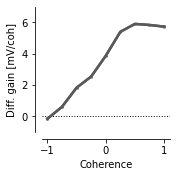

In [48]:
fig = plt.figure(figsize = (2.3, 2.3))

ax = fig.add_subplot(111) #PLOT slopes of coherence tuning

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)
plt.plot(coh, np.mean(slope_coh_ctrl_min_block,1), linewidth = 2.5, color = '0.35')
plt.errorbar(coh, np.mean(slope_coh_ctrl_min_block,1), yerr = stats.sem(slope_coh_ctrl_min_block,1),
             linewidth = 2.5, color = '0.35')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
#for axis in ['top','bottom','left','right']:
#  ax.spines[axis].set_linewidth(0.5)
ax.set_xlabel('Coherence', fontsize = 10)
ax.set_ylabel('Diff. gain [mV/coh]', fontsize = 10)
plt.ylim([-1,7])
#ax.set_xticks(xticks)
#ax.set_yticks([-5, 0, 5])
#ax.set_yticklabels([-5, 0, 5], size=10)

#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\Modelling\\\
#FigS7_Diff_Gain_tuning_VS_LV_block_300rep.pdf',bbox_inches='tight', dpi=600, transparent=True)

bbox_inches = 'tight'
plt.show()

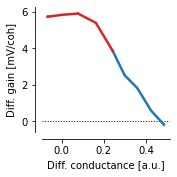

In [49]:
fig = plt.figure(figsize = (2.3, 2.3))

ax = fig.add_subplot(111) #PLOT slopes of coherence tuning

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)

#plt.plot(coh, np.mean(slope_coh_ctrl_min_block,1), linewidth = 2.5, color = '0.35')
#plt.errorbar(coh, np.mean(slope_coh_ctrl_min_block,1), yerr = stats.sem(slope_coh_ctrl_min_block,1),
#             linewidth = 2.5, color = '0.35')

#plt.errorbar(np.mean(R24E09_ArcLight_meandata_align, axis=0), np.mean(R24E09_scb_Ftrace_mean, axis=0),\
 #            xerr = stats.sem(R24E09_ArcLight_meandata_align, axis=0),
  #           yerr = stats.sem(R24E09_scb_Ftrace_mean, axis=0), fmt='none', color = 'C2')

plt.plot(np.mean(delta_g_ctrl_min_block,1)[0:5], np.mean(slope_coh_ctrl_min_block[0:5],1), linewidth = 2.5, color = 'C0')
plt.errorbar(np.mean(delta_g_ctrl_min_block,1)[0:5], np.mean(slope_coh_ctrl_min_block[0:5],1), 
             xerr = stats.sem(delta_g_ctrl_min_block,1)[0:5],
             yerr = stats.sem(slope_coh_ctrl_min_block,1)[0:5], fmt='none', color = 'C0')

plt.plot(np.mean(delta_g_ctrl_min_block,1)[4:9], np.mean(slope_coh_ctrl_min_block[4:9],1), linewidth = 2.5, color = 'C3')
plt.errorbar(np.mean(delta_g_ctrl_min_block,1)[4:9], np.mean(slope_coh_ctrl_min_block[4:9],1), 
             xerr = stats.sem(delta_g_ctrl_min_block,1)[4:9],
             yerr = stats.sem(slope_coh_ctrl_min_block,1)[4:9], fmt='none', color = 'C3')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
#for axis in ['top','bottom','left','right']:
#  ax.spines[axis].set_linewidth(0.5)
ax.set_xlabel('Diff. conductance [a.u.]', fontsize = 10)
ax.set_ylabel('Diff. gain [mV/coh]', fontsize = 10)
#xticks = np.array([-0.5, -0.25, 0, 0.25, 0.5])
#ax.set_xticklabels([-0.5, -0.25, 0, 0.25, 0.5], size=10)
#plt.ylim([-0.5,5])
#ax.set_xticks(xticks)
#ax.set_yticks([-5, 0, 5])
#ax.set_yticklabels([-5, 0, 5], size=10)

#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\Modelling\\\
#FigS7_Gain_vs_conductance_tuning_VS_LL_block_300rep.pdf',bbox_inches='tight', dpi=600, transparent=True)

bbox_inches = 'tight'
plt.show()

In [50]:
stats.pearsonr(np.mean(delta_g_ctrl_min_block,1)[0:5], np.mean(slope_coh_ctrl_min_block[0:5],1))

(-0.9943624479144985, 0.0005076940974062631)

In [51]:
stats.pearsonr(np.mean(delta_g_ctrl_min_block,1)[4:9], np.mean(slope_coh_ctrl_min_block[4:9],1))

(-0.7912793833846465, 0.11081400926851534)

In [52]:
pearson_PD = np.empty([rep])
pearson_ND = np.empty([rep])
for i in range(rep):
    statistic_PD, p_value_PD = stats.pearsonr(delta_g_ctrl_min_block[4:9,i], slope_coh_ctrl_min_block[4:9,i])
    pearson_PD[i] = statistic_PD
    
    statistic_ND, p_value_ND = stats.pearsonr(delta_g_ctrl_min_block[0:5,i], slope_coh_ctrl_min_block[0:5,i])
    pearson_ND[i] = statistic_ND

In [53]:
np.mean(pearson_PD)

-0.4571089415134281

In [54]:
np.mean(pearson_ND)

-0.7377730470795442

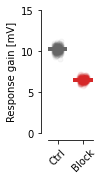

In [55]:
# Make Scatter Plot Gain (slope)

pos = [0,1]
fw = 0.4
fig = plt.figure(figsize = (fw*len(pos), 2.25))
ax = fig.add_subplot(111)
w = 0.6
wb = 0.6

data = [slope_int_ctrl[0,:], slope_int_block[0,:]]
colors = ['0.4', 'C3']

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)

for j in range (len(data)):
    ax.plot([pos[j]-w/2, pos[j]+w/2],[np.mean(data[j]),np.mean(data[j])],
            color=colors[j], linestyle='-', linewidth = 4)
    ax.errorbar(pos[j],np.mean(data[j]),yerr=[stats.sem(data[j])], color='k',zorder = 0)    
    for i in range(len(data[j])):
        ax.scatter(pos[j] + np.random.random(1) * w/2 - w/4, data[j][i], s=25, color=colors[j], alpha=0.05, zorder = 2) 
   
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
ax.set_xticks(pos)
ax.set_xticklabels(('Ctrl','Block'), rotation=45, size=10)
ax.set_ylabel('Response gain [mV]', size=10)
yticks = np.array([0, 5, 10, 15])
ax.set_yticklabels([0, 5, 10, 15], size=10)
ax.set_yticks(yticks)
plt.ylim([0, 15])
#plt.title('Gain', size=10)
    
bbox_inches = 'tight'
#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\\
#Fig7_Conductance_global_model_ctrl_block_barplot.pdf',bbox_inches='tight', dpi=600, transparent=True)
plt.show()

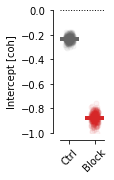

In [56]:
# Make Scatter Plot Gain (slope)

pos = [0,1]
fw = 0.4
fig = plt.figure(figsize = (fw*len(pos), 2.25))
ax = fig.add_subplot(111)
w = 0.6
wb = 0.6

data = [slope_int_ctrl[1,:], slope_int_block[1,:]]
colors = ['0.4', 'C3']

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)

for j in range (len(data)):
    ax.plot([pos[j]-w/2, pos[j]+w/2],[np.mean(data[j]),np.mean(data[j])],
            color=colors[j], linestyle='-', linewidth = 4)
    ax.errorbar(pos[j],np.mean(data[j]),yerr=[stats.sem(data[j])], color='k',zorder = 0)    
    for i in range(len(data[j])):
        ax.scatter(pos[j] + np.random.random(1) * w/2 - w/4, data[j][i], s=25, color=colors[j], alpha=0.05, zorder = 2) 
   
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
ax.set_xticks(pos)
ax.set_xticklabels(('Ctrl','Block'), rotation=45, size=10)
ax.set_ylabel('Intercept [coh]', size=10)
#yticks = np.array([0, 5, 10])
#ax.set_yticklabels([0, 5, 10], size=10)
#ax.set_yticks(yticks)
plt.ylim([-1, 0])
#plt.title('Gain', size=10)
    
bbox_inches = 'tight'
#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\\
#Fig7_Conductance_global_model_ctrl_block_barplot.pdf',bbox_inches='tight', dpi=600, transparent=True)
plt.show()

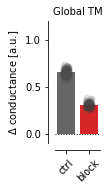

In [57]:
# Make Scatter Plot of Ephys conductance (Split ctrl vs. block)

pos = [0,1]

fig = plt.figure(figsize = (fw*len(pos), 2.25))

ax = fig.add_subplot(111)
w = 0.6
wb = 0.6

data = [delta_g_ctrl_mean[9], delta_g_block_mean[9]]
colors = ['0.4', 'C3']

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)

for j in range (len(data)):
    ax.bar(pos[j], height = np.mean(data[j]), color=colors[j])
    ax.errorbar(pos[j],np.mean(data[j]),yerr=[stats.sem(data[j])], color='k',zorder = 0)    
    for i in range(len(data[j])):
        ax.scatter(pos[j] + np.random.random(1) * w/2 - w/4, data[j][i], s=25, color='0.3', alpha=0.05, zorder = 2)
   
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
ax.set_xticks(pos)
ax.set_xticklabels(('ctrl','block'), rotation=45, size=10)
ax.set_ylabel(r'$\Delta$'+ ' conductance [a.u.]', size=10)
yticks = np.array([0, 0.5, 1, 1.5, 2])
ax.set_yticklabels([0.0, 0.5, 1.0, 1.5, 2], size=10)
ax.set_yticks(yticks)
plt.ylim([-0.1, 1.2])
plt.title('Global TM', size=10)
    
bbox_inches = 'tight'
#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\\
#Fig7_Conductance_global_model_ctrl_block_barplot.pdf',bbox_inches='tight', dpi=600, transparent=True)
plt.show()

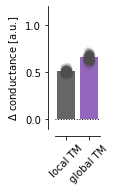

In [58]:
# Make Scatter Plot of Ephys conductance (TM vs. Split)

pos = [0,1]

fig = plt.figure(figsize = (fw*len(pos), 2.25))

ax = fig.add_subplot(111)
w = 0.6
wb = 0.6

data = [delta_g_ctrl_mean[4], delta_g_ctrl_mean[9]]
colors = ['0.4', 'C4']

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)

for j in range (len(data)):
    ax.bar(pos[j], height = np.mean(data[j]), color=colors[j])
    ax.errorbar(pos[j],np.mean(data[j]),yerr=[stats.sem(data[j])], color='k',zorder = 0)    
    for i in range(len(data[j])):
        ax.scatter(pos[j] + np.random.random(1) * w/2 - w/4, data[j][i], s=25, color='0.3', alpha=0.05, zorder = 2)
   
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
ax.set_xticks(pos)
ax.set_xticklabels(('local TM','global TM'), rotation=45, size=10)
ax.set_ylabel(r'$\Delta$'+ ' conductance [a.u.]', size=10)
yticks = np.array([0, 0.5, 1, 1.5, 2])
ax.set_yticklabels([0.0, 0.5, 1.0, 1.5, 2], size=10)
ax.set_yticks(yticks)
plt.ylim([-0.1, 1.2])

bbox_inches = 'tight'
#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\\
#Fig7_Conductance_local_global_model_barplot.pdf',bbox_inches='tight', dpi=600, transparent=True)
plt.show()

In [59]:
np.mean(delta_g_ctrl_mean[9]) / np.mean(delta_g_ctrl_mean[4])

1.285264100385605

In [60]:
stats.ttest_rel(delta_g_ctrl_mean[4], delta_g_ctrl_mean[9])

Ttest_relResult(statistic=-59.676245097368664, pvalue=3.93451540989913e-168)

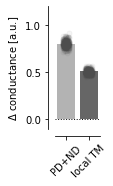

In [101]:
# Make Scatter Plot of modelling conductance (TM local: PD+ND vs. TM)

pos = [0,1]

fig = plt.figure(figsize = (fw*len(pos), 2.25))

ax = fig.add_subplot(111)
w = 0.6
wb = 0.6
data = [delta_g_ctrl_mean[0] + delta_g_ctrl_mean[8], delta_g_ctrl_mean[4]]
colors = ['0.7', '0.4']

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)

for j in range (len(data)):
    ax.bar(pos[j], height = np.mean(data[j]), color=colors[j])
    ax.errorbar(pos[j],np.mean(data[j]),yerr=[stats.sem(data[j])], color='k',zorder = 0)    
    for i in range(len(data[j])):
        ax.scatter(pos[j] + np.random.random(1) * w/2 - w/4, data[j][i], s=25, color='0.3', alpha=0.05, zorder = 2)
   
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
ax.set_xticks(pos)
ax.set_xticklabels(('PD+ND','local TM'), rotation=45, size=10)
ax.set_ylabel(r'$\Delta$'+ ' conductance [a.u.]', size=10)
yticks = np.array([0, 0.5, 1, 1.5, 2])
ax.set_yticklabels([0.0, 0.5, 1.0, 1.5, 2.0], size=10)
ax.set_yticks(yticks)
plt.ylim([-0.1, 1.2])

bbox_inches = 'tight'
#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\\
#Fig7_Conductance_TM_PDND_model_barplot.pdf',bbox_inches='tight', dpi=600, transparent=True)
plt.show()

In [102]:
stats.ttest_rel((delta_g_ctrl_mean[0] + delta_g_ctrl_mean[8]), delta_g_ctrl_mean[4])

Ttest_relResult(statistic=125.07735012742474, pvalue=3.1264150708401052e-260)

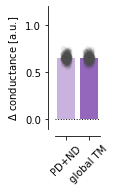

In [136]:
# Make Scatter Plot of modelling conductance (Split global: PD+ND vs. Split)

pos = [0,1]

fig = plt.figure(figsize = (fw*len(pos), 2.25))

ax = fig.add_subplot(111)
w = 0.6
wb = 0.6
data = [delta_g_ctrl_mean[9], delta_g_ctrl_mean[9]]
colors = ['C4', 'C4']
alphas = ([0.5, 1])

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)

for j in range (len(data)):
    ax.bar(pos[j], height = np.mean(data[j]), color=colors[j], alpha=alphas[j])
    ax.errorbar(pos[j],np.mean(data[j]),yerr=[stats.sem(data[j])], color='k',zorder = 0)    
    for i in range(len(data[j])):
        ax.scatter(pos[j] + np.random.random(1) * w/2 - w/4, data[j][i], s=25, color='0.3', alpha=0.05, zorder = 2)
   
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
ax.set_xticks(pos)
ax.set_xticklabels(('PD+ND','global TM'), rotation=45, size=10)
ax.set_ylabel(r'$\Delta$'+ ' conductance [a.u.]', size=10)
yticks = np.array([0, 0.5, 1, 1.5, 2])
ax.set_yticklabels([0.0, 0.5, 1.0, 1.5, 2.0], size=10)
ax.set_yticks(yticks)
plt.ylim([-0.1,1.2])

bbox_inches = 'tight'
#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\\
#Fig7_Conductance_Split_PDND_model_barplot.pdf',bbox_inches='tight', dpi=600, transparent=True)
plt.show()

In [115]:
stats.ttest_ind(delta_g_ctrl_mean[9], delta_g_ctrl_mean[9])

Ttest_indResult(statistic=0.0, pvalue=1.0)

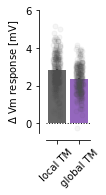

In [135]:
# Make Scatter Plot of Ephys voltage (TM vs. Split)

pos = [0, 1]

fig = plt.figure(figsize = (fw * len(pos), 2.25))

ax = fig.add_subplot(111)
w = 0.6
wb = 0.6
data = [delta_VS_ctrl_mean[4], delta_VS_ctrl_mean[9]]
colors = ['0.4', 'C4']

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)

for j in range (len(data)):
    ax.bar(pos[j], height = np.mean(data[j]), color = colors[j])
    ax.errorbar(pos[j],np.mean(data[j]),yerr=[stats.sem(data[j])], color='k',zorder = 0)    
    for i in range(len(data[j])):
        ax.scatter(pos[j] + np.random.random(1) * w/2 - w/4, data[j][i], s=25, color='0.3', alpha=0.05, zorder = 2)
   
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
ax.set_xticks(pos)
ax.set_xticklabels(('local TM','global TM'), rotation=45, size=10)
ax.set_ylabel(r'$\Delta$'+ ' Vm response [mV]', size=10)
#yticks = np.array([0, 1, 2, 3, 4, 5])
#ax.set_yticklabels([0, 1, 2, 3, 4, 5], size=11)
#ax.set_yticks(yticks)
plt.ylim([-0.5, 6])

bbox_inches = 'tight'
#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\\
#Fig7_Voltage_local_global_model_barplot.pdf',bbox_inches='tight', dpi=600, transparent=True)
plt.show()

In [118]:
stats.ttest_rel(delta_VS_ctrl_mean[4], delta_VS_ctrl_mean[9])

Ttest_relResult(statistic=6.587104305554231, pvalue=2.0175671632273294e-10)

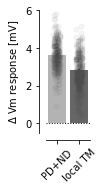

In [134]:
# Make Scatter Plot of Ephys voltage (TM vs. Split)

pos = [0, 1]

fig = plt.figure(figsize = (fw * len(pos), 2.25))

ax = fig.add_subplot(111)
w = 0.6
wb = 0.6
data = [delta_VS_ctrl_mean[0] + delta_VS_ctrl_mean[8], delta_VS_ctrl_mean[4]]
colors = ['0.7', '0.4']

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)

for j in range (len(data)):
    ax.bar(pos[j], height = np.mean(data[j]), color = colors[j])
    ax.errorbar(pos[j],np.mean(data[j]),yerr=[stats.sem(data[j])], color='k',zorder = 0)    
    for i in range(len(data[j])):
        ax.scatter(pos[j] + np.random.random(1) * w/2 - w/4, data[j][i], s=25, color='0.3', alpha=0.05, zorder = 2)

   
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
ax.set_xticks(pos)
ax.set_xticklabels(('PD+ND','local TM'), rotation=45, size=10)
ax.set_ylabel(r'$\Delta$'+ ' Vm response [mV]', size=10)
#yticks = np.array([0, 1, 2, 3, 4, 5])
#ax.set_yticklabels([0, 1, 2, 3, 4, 5], size=11)
#ax.set_yticks(yticks)
plt.ylim([-0.5, 6])

bbox_inches = 'tight'
#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\\
#Fig7_Voltage_TM_PDND_model_barplot.pdf',bbox_inches='tight', dpi=600, transparent=True)
plt.show()

In [120]:
stats.ttest_rel((delta_VS_ctrl_mean[0] + delta_VS_ctrl_mean[8]), delta_VS_ctrl_mean[4])

Ttest_relResult(statistic=12.050651318670917, pvalue=1.5878010083825835e-27)

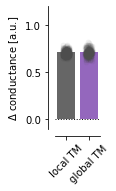

In [133]:
# Make Scatter Plot of modelling conductance (Split global: PD+ND vs. Split)

pos = [0,1]

fig = plt.figure(figsize = (fw*len(pos), 2.25))

ax = fig.add_subplot(111)
w = 0.6
wb = 0.6

data = [delta_g_block_mean[4], delta_g_block_mean[9]]

colors = ['0.4', 'C4']

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)

for j in range (len(data)):
    ax.bar(pos[j], height = np.mean(data[j]), color=colors[j])
    ax.errorbar(pos[j],np.mean(data[j]),yerr=[stats.sem(data[j])], color='k',zorder = 0)    
    for i in range(len(data[j])):
        ax.scatter(pos[j] + np.random.random(1) * w/2 - w/4, data[j][i], s=25, color='0.3', alpha=0.05, zorder = 2)
   
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
ax.set_xticks(pos)
ax.set_xticklabels(('local TM','global TM'), rotation=45, size=10)
ax.set_ylabel(r'$\Delta$'+ ' conductance [a.u.]', size=10)
yticks = np.array([0, 0.5, 1, 1.5, 2])
ax.set_yticklabels([0.0, 0.5, 1.0, 1.5, 2.0], size=10)
ax.set_yticks(yticks)
plt.ylim([-0.1, 1.2])
#plt.title('Feedback block')

bbox_inches = 'tight'
#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\\
#Fig7_Conductance_model_barplot_comp_ctrl_block.pdf',bbox_inches='tight', dpi=600, transparent=True)
plt.show()

In [122]:
np.mean(delta_g_block_mean[4])/np.mean(delta_g_block_mean[9])

1.0022700671521865

In [123]:
stats.ttest_rel(delta_g_block_mean[4], delta_g_block_mean[9])

Ttest_relResult(statistic=0.617147352187203, pvalue=0.5376072081657177)

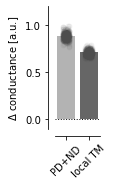

In [132]:
# Make Scatter Plot of modelling conductance (Split global: PD+ND vs. Split)

pos = [0,1]

fig = plt.figure(figsize = (fw*len(pos), 2.25))

ax = fig.add_subplot(111)
w = 0.6
wb = 0.6

data = [delta_g_block_mean[0] + delta_g_block_mean[8], delta_g_block_mean[4]]

colors = ['0.7', '0.4']

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)

for j in range (len(data)):
    ax.bar(pos[j], height = np.mean(data[j]), color=colors[j])
    ax.errorbar(pos[j],np.mean(data[j]),yerr=[stats.sem(data[j])], color='k',zorder = 0)    
    for i in range(len(data[j])):
        ax.scatter(pos[j] + np.random.random(1) * w/2 - w/4, data[j][i], s=25, color='0.3', alpha=0.05, zorder = 2)
   
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
ax.set_xticks(pos)
ax.set_xticklabels(('PD+ND','local TM'), rotation=45, size=10)
ax.set_ylabel(r'$\Delta$'+ ' conductance [a.u.]', size=10)
yticks = np.array([0, 0.5, 1, 1.5, 2])
ax.set_yticklabels([0.0, 0.5, 1.0, 1.5, 2.0], size=10)
ax.set_yticks(yticks)
plt.ylim([-0.1, 1.2])
#plt.title('Feedback block')

bbox_inches = 'tight'
#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\\
#Fig7_Conductance_model_TM_PDND_model_block_barplot.pdf',bbox_inches='tight', dpi=600, transparent=True)
plt.show()

In [125]:
stats.ttest_ind(delta_g_block_mean[0] + delta_g_block_mean[8], delta_g_block_mean[4])

Ttest_indResult(statistic=63.74772129049442, pvalue=7.585941355347158e-269)

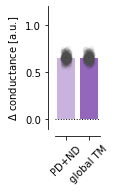

In [130]:
# Make Scatter Plot of modelling conductance (Split global: PD+ND vs. Split)

pos = [0,1]

fig = plt.figure(figsize = (fw*len(pos), 2.25))

ax = fig.add_subplot(111)
w = 0.6
wb = 0.6

data = [delta_g_ctrl_mean[9], delta_g_ctrl_mean[9]]

colors = ['C4', 'C4']
alphas = ([0.5, 1])

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)

for j in range (len(data)):
    ax.bar(pos[j], height = np.mean(data[j]), color=colors[j], alpha=alphas[j])
    ax.errorbar(pos[j],np.mean(data[j]),yerr=[stats.sem(data[j])], color='k',zorder = 0)    
    for i in range(len(data[j])):
        ax.scatter(pos[j] + np.random.random(1) * w/2 - w/4, data[j][i], s=25, color='0.3', alpha=0.05, zorder = 2)
   
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
ax.set_xticks(pos)
ax.set_xticklabels(('PD+ND','global TM'), rotation=45, size=10)
ax.set_ylabel(r'$\Delta$'+ ' conductance [a.u.]', size=10)
yticks = np.array([0, 0.5, 1, 1.5, 2])
ax.set_yticklabels([0.0, 0.5, 1.0, 1.5, 2.0], size=10)
ax.set_yticks(yticks)
plt.ylim([-0.1,1.2])
#plt.title('Feedback block')

bbox_inches = 'tight'
#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\\
#Fig7_Conductance_model_Split_PDND_model_block_barplot.pdf',bbox_inches='tight', dpi=600, transparent=True)
plt.show()

In [127]:
stats.ttest_ind(delta_g_block_mean[9], delta_g_block_mean[9])

Ttest_indResult(statistic=0.0, pvalue=1.0)

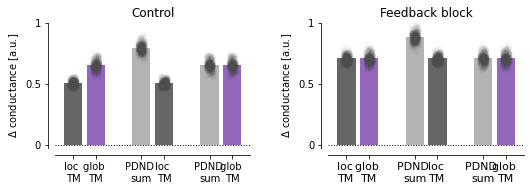

In [128]:
# Make Scatter Plot of modelling conductance (Split global: PD+ND vs. Split)

pos = [0,1,3,4,6,7]

fig = plt.figure(figsize = (1.4*len(pos),2.3))
plt.subplots_adjust(wspace = 0.4)

ax = fig.add_subplot(121)
w = 0.6
wb = 0.6
data = [delta_g_ctrl_mean[4], delta_g_ctrl_mean[9],
        delta_g_ctrl_mean[0] + delta_g_ctrl_mean[8], delta_g_ctrl_mean[4],
        delta_g_ctrl_mean[9], delta_g_ctrl_mean[9]]

colors = ['0.4', 'C4', '0.7', '0.4', '0.7', 'C4']

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)

for j in range (len(data)):
    ax.bar(pos[j], height = np.mean(data[j]), color=colors[j])
    ax.errorbar(pos[j],np.mean(data[j]),yerr=[stats.sem(data[j])], color='k',zorder = 0)    
    for i in range(len(data[j])):
        ax.scatter(pos[j] + np.random.random(1) * w/2 - w/4, data[j][i], s=25, color='0.3', alpha=0.03, zorder = 2)
   
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
ax.set_xticks(pos)
ax.set_xticklabels(('loc \nTM','glob \nTM', 'PDND \nsum', 'loc \nTM', 'PDND \nsum', 'glob \nTM'), size=10)
ax.set_ylabel(r'$\Delta$'+ ' conductance [a.u.]', size=10)
yticks = np.array([0, 0.5, 1, 1.5, 2])
ax.set_yticklabels([0, 0.5, 1, 1.5, 2], size=10)
ax.set_yticks(yticks)
plt.ylim([-0.03,1])
plt.title('Control')


ax = fig.add_subplot(122)
w = 0.6
wb = 0.6
data = [delta_g_block_mean[4], delta_g_block_mean[9],
        delta_g_block_mean[0] + delta_g_block_mean[8], delta_g_block_mean[4],
        delta_g_block_mean[9], delta_g_block_mean[9]]
colors = ['0.4', 'C4', '0.7', '0.4', '0.7', 'C4']

ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 1)

for j in range (len(data)):
    ax.bar(pos[j], height = np.mean(data[j]), color=colors[j])
    ax.errorbar(pos[j],np.mean(data[j]),yerr=[stats.sem(data[j])], color='k',zorder = 0)    
    for i in range(len(data[j])):
        ax.scatter(pos[j] + np.random.random(1) * w/2 - w/4, data[j][i], s=25, color='0.3', alpha=0.03, zorder = 2)
   
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))
ax.set_xticks(pos)
ax.set_xticklabels(('loc \nTM','glob \nTM', 'PDND \nsum', 'loc \nTM', 'PDND \nsum', 'glob \nTM'), size=11)
ax.set_ylabel(r'$\Delta$'+ ' conductance [a.u.]', size=10)
yticks = np.array([0, 0.5, 1, 1.5, 2])
ax.set_yticklabels([0, 0.5, 1, 1.5, 2], size=10)
ax.set_yticks(yticks)
plt.ylim([-0.03,1])
plt.title('Feedback block')

bbox_inches = 'tight'
#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\\
#Fig7_Conductance_model_barplot_comp_ctrl_block_all.pdf',bbox_inches='tight', dpi=600, transparent=True)
plt.show()

In [102]:
# Calculate ratios of the different conductances
g_ratios = np.empty([3,2])

g_ratios[0,0] = np.mean(delta_g_ctrl_mean[4]) / np.mean(delta_g_ctrl_mean[9])
g_ratios[0,1] = np.mean(delta_g_block_mean[4]) / np.mean(delta_g_block_mean[9])
g_ratios[1,0] = np.mean(delta_g_ctrl_mean[0] + delta_g_ctrl_mean[8]) / np.mean(delta_g_ctrl_mean[4])
g_ratios[1,1] = np.mean(delta_g_block_mean[0] + delta_g_block_mean[8]) / np.mean(delta_g_block_mean[4])
g_ratios[2,0] = np.mean(delta_g_ctrl_mean[9]) / np.mean(delta_g_ctrl_mean[9])
g_ratios[2,1] = np.mean(delta_g_block_mean[9]) / np.mean(delta_g_block_mean[9])

g_ratios_ephys = np.load('g_ratios_ephys.npy')

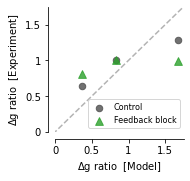

In [103]:
fig = plt.figure(figsize = (2.3, 2.3))

#plt.subplots_adjust(wspace = 0.1)

ax = fig.add_subplot(111)
#ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 2)

plt.plot([-0.5,1.8],[-0.5,1.8], color='0.7', linestyle='--')
plt.scatter(g_ratios_ephys**-1, g_ratios[:,0]**-1, 170, color = '0.3', marker='.', alpha=0.8, label = 'Control')
plt.scatter(g_ratios_ephys**-1, g_ratios[:,1]**-1, 60, color = 'C2', marker ='^', alpha=0.8, label = 'Feedback block')

plt.legend(loc=4, frameon=True, fontsize=8)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['left'].set_position(('outward', 7))
ax.spines['bottom'].set_position(('outward', 7))

xticks = np.array([0, 0.5, 1, 1.5])
ax.set_xticklabels([0, 0.5, 1, 1.5], size=10)
ax.set_xticks(xticks)

yticks = np.array([0, 0.5, 1, 1.5])
ax.set_yticklabels([0, 0.5, 1, 1.5], size=10)
ax.set_yticks(yticks)

ax.set_xlabel(r'$\Delta$'+ 'g ratio  [Model]', size=10)
ax.set_ylabel(r'$\Delta$'+ 'g ratio  [Experiment]', size=10)

plt.xlim([0, 1.75])
plt.ylim([0, 1.75])

bbox_inches = 'tight'
#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\\
#Fig7_voltage_local_global_model_traces.pdf',bbox_inches='tight', dpi=600, transparent=True)
plt.show()

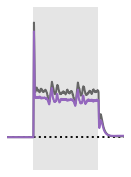

In [104]:
fig = plt.figure(figsize = (2.1,3))

#plt.subplots_adjust(wspace = 0.1)

ax = fig.add_subplot(111)
ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 2)
plt.plot(time, np.mean(delta_VS_ctrl_loop[4,:,:],1), color = '0.4', linewidth = 2)
plt.plot(time, np.mean(delta_VS_ctrl_loop[9,:,:],1), color = 'C4', linewidth = 2)

plt.axvspan(2.5, 7.5, facecolor='0.5', alpha=0.2)
plt.xlim([0.5,9.5])
plt.ylim([-2,8])
plt.axis('off') 

bbox_inches = 'tight'
#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\\
#Fig7_voltage_local_global_model_traces.pdf',bbox_inches='tight', dpi=600, transparent=True)
plt.show()

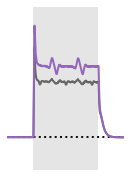

In [105]:
fig = plt.figure(figsize = (2.1,3))

#plt.subplots_adjust(wspace = 0.1)

ax = fig.add_subplot(111)
ax.axhline(y=0,xmin=0.0001,xmax=0.9999, color='0.05', linestyle=':', linewidth = 2)
plt.plot(time, np.mean(delta_g_ctrl_loop[4,:,:],1), color = '0.4', linewidth = 2)
plt.plot(time, np.mean(delta_g_ctrl_loop[9,:,:],1), color = 'C4', linewidth = 2)

plt.axvspan(2.5, 7.5, facecolor='0.5', alpha=0.2)
plt.xlim([0.5,9.5])
plt.ylim([-0.3,1.2])
plt.axis('off') 

bbox_inches = 'tight'
#plt.savefig('C:\\Users\\gammer\\Desktop\\DATA Surface\\LPi Opponency\\plots_LPi_ms\\\
#Fig7_conductance_local_global_model_traces.pdf',bbox_inches='tight', dpi=600, transparent=True)
plt.show()